<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/full_detection_TCN_QTDB%2BLUDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir /content/physionet.org/
!mkdir /content/physionet.org/files/
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/ludb' '/content/physionet.org/files/'
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/qtdb' '/content/physionet.org/files/'

In [2]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


# preprocess

In [3]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [4]:
def bandpass_filter(signal, lowcut=0.5, highcut=10, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)

In [5]:

from scipy.signal import resample

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    """
    Rescales annotation sample indices from original_fs to target_fs.
    Works with scalars or lists/arrays.
    """
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)



In [6]:
def extract_wave_regions(samples, symbols, fs, extra_ms={'p':0,'N':20,'t':0}):
    wave_regions = {'p': [], 'N': [], 't': []}
    start = None
    qrs_symbols = ['N', 'L', 'R', 'V', 'A']
    current_symbol = None
    a = fs/ 1000
    for i in range(len(symbols)):

        if symbols[i] == '(':
            start = samples[i]
            current_symbol = None
        elif symbols[i] in wave_regions:

            current_symbol = symbols[i]
        elif symbols[i] in qrs_symbols:
            current_symbol = 'N'
        elif symbols[i] == ')' and current_symbol:
            end = samples[i]
            if start and end and current_symbol:
              #print(extra_ms['p'])
              wave_regions[current_symbol].append((int(start-extra_ms[current_symbol]*a), int(end+extra_ms[current_symbol]*a)))

            start = None
            current_symbol = None
    return wave_regions


In [7]:
def create_multi_class_mask(length, wave_regions):
    mask = np.zeros((length, 3))  # [P, QRS, T]
    label_map = {'p': 0, 'N': 1, 't': 2}
    for label, regions in wave_regions.items():
        for start, end in regions:
            mask[start:end, label_map[label]] = 1
    return mask


In [8]:
def segment_signal_and_mask(signal, mask, window_size, fs):
    segments = []
    masks = []
    for i in range(0, len(signal) - window_size, window_size // 5):  # 2% overlap
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        segments.append(segment)
        masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [9]:

def process_record(record_path, Type, extra_ms={'p':0,'N':20,'t':0}):
    # Load signal
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # Use lead I
    if Type=='QTDB':
      annotations = wfdb.rdann(record_path, 'pu0')
    else:
      annotations = wfdb.rdann(record_path, 'i')
    samples = annotations.sample  # Annotation sample locations
    symbols = annotations.symbol  # Annotation symbols
    fs = record.fs  # Sampling frequency (500 Hz)

    # Preprocess
    signal = normalize_signal(smooth_signal(bandpass_filter(signal,fs=fs)))
    # Resampling to 250 Hz
    if fs!=250:
      # Example: Resample QTDB signal from 500 Hz to 250 Hz
      signal = resample_signal(signal, original_fs=fs, target_fs=250)

      # Example: Adjust QTDB annotations
      samples = adjust_annotations(samples,original_fs=fs,target_fs=250)
      fs=250
    # Extract QRS
    if Type=='QTDB':
      qrs_regions = extract_wave_regions(samples, symbols,fs,extra_ms=extra_ms)
    else :
      qrs_regions = extract_wave_regions(samples, symbols,fs)
    # Create binary masks
    mask = create_multi_class_mask(len(signal), qrs_regions)

    # Segment the signals and masks
    #window_size = int(1 * fs)  # 1-second window (based on LUDB's fs)
    window_size = int(1 * fs)  # 150 ms window (based on LUDB's fs)
    segments, masks = segment_signal_and_mask(signal, mask, window_size, fs)

    return segments, masks


In [10]:
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  # Ensure no duplicates

# Set paths for QTDB and LUDB
qtdb_path = "/content/physionet.org/files/qtdb/1.0.0/"
ludb_path = "/content/physionet.org/files/ludb/1.0.1/data/"

# Get all record names dynamically
qt_records = get_all_records(qtdb_path)
lu_records = get_all_records(ludb_path)

print(f"Found {len(qt_records)} QTDB records and {len(lu_records)} LUDB records.")

Found 105 QTDB records and 200 LUDB records.


In [11]:
qt_segments_list, qt_masks_list = [], []

for record_path in qt_records:
    try:
        print(f"Processing {record_path}")
        segments, masks = process_record(qtdb_path+record_path, Type='QTDB', extra_ms={'p':0,'N':20,'t':0})  # Resample to 250 Hz
        qt_segments_list.append(segments)
        qt_masks_list.append(masks)
    except:
        print(f"Skipping {record_path} due to error.")

Processing sele0409
Processing sel230
Processing sel16795
Processing sele0411
Processing sel100
Processing sel116
Processing sele0133
Processing sele0110
Processing sel872
Processing sel39
Processing sel307
Processing sel308
Processing sel871
Processing sel16272
Processing sele0704
Processing sele0126
Processing sel102
Processing sel45
Processing sel42
Processing sele0111
Processing sele0116
Processing sel16273
Processing sel16265
Processing sel117
Processing sel103
Processing sel14172
Processing sel48
Processing sele0170
Processing sel14046
Processing sel43
Processing sel40
Processing sele0114
Processing sel17152
Processing sel49
Processing sele0604
Processing sel847
Processing sel213
Processing sele0612
Processing sele0104
Processing sel114
Processing sele0609
Processing sel50
Processing sel231
Processing sele0603
Processing sel233
Processing sel302
Processing sel803
Processing sel30
Processing sel104
Processing sel32
Processing sele0406
Processing sele0112
Processing sel46
Processin

In [12]:

lu_segments_list, lu_masks_list = [], []
for record_path in lu_records:
    try:
        print(f"Processing {record_path}")
        segments, masks = process_record(ludb_path+record_path, Type='LUDB', extra_ms=20)
        lu_segments_list.append(segments)
        lu_masks_list.append(masks)
    except:
        print(f"Skipping {record_path} due to error.")

Processing 30
Processing 72
Processing 158
Processing 192
Processing 163
Processing 145
Processing 18
Processing 35
Processing 132
Processing 47
Processing 32
Processing 167
Processing 26
Processing 33
Processing 122
Processing 141
Processing 7
Processing 152
Processing 28
Processing 64
Processing 121
Processing 166
Processing 91
Processing 22
Processing 38
Processing 21
Processing 46
Processing 165
Processing 41
Processing 143
Processing 87
Processing 140
Processing 13
Processing 8
Processing 114
Processing 25
Processing 73
Processing 103
Processing 183
Processing 112
Processing 148
Processing 40
Processing 70
Processing 49
Processing 119
Processing 110
Processing 156
Processing 138
Processing 27
Processing 127
Processing 189
Processing 66
Processing 67
Processing 181
Processing 14
Processing 52
Processing 184
Processing 31
Processing 149
Processing 199
Processing 86
Processing 37
Processing 196
Processing 117
Processing 177
Processing 191
Processing 101
Processing 19
Processing 195
P

In [13]:
qt_segments = np.concatenate(qt_segments_list, axis=0)
qt_masks = np.concatenate(qt_masks_list, axis=0)
lu_segments = np.concatenate(lu_segments_list, axis=0)
lu_masks = np.concatenate(lu_masks_list, axis=0)

In [14]:
# Combine into final dataset
X = np.concatenate([qt_segments, lu_segments])

qt_segments = None
lu_segments = None
qt_segments_list = None
lu_segments_list = None

In [15]:

y = np.concatenate([qt_masks, lu_masks])

In [16]:
qt_masks = None
lu_masks = None
qt_masks_list = None
lu_masks_list = None

# split dataset

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [18]:
X=None
Y=None

# model and training

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU, Add,
    Dense, Dropout, LayerNormalization
)
import tensorflow as tf

from tensorflow.keras.utils import register_keras_serializable

def residual_block(x, filters, kernel_size, dilation_rate, dropout_rate):
    res = x

    # First conv layer
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    # Second conv layer
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)

    # Match dimensions for residual if needed
    if res.shape[-1] != x.shape[-1]:
        res = Conv1D(filters, kernel_size=1, padding='same')(res)

    x = Add()([x, res])
    x = ReLU()(x)
    return x

def Improved_TCN(input_shape, num_filters=64, kernel_size=3, num_blocks=6, dropout_rate=0.2):
    inputs = Input(shape=input_shape)
    x = inputs
    for i in range(num_blocks):
        x = residual_block(x, num_filters, kernel_size, dilation_rate=2**i, dropout_rate=dropout_rate)

    # Output 3 channels: P, QRS, T
    outputs = Conv1D(3, kernel_size=1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model
window_size=int(250*1)
input_shape = (window_size, 1)
model = Improved_TCN(input_shape, num_filters=64, kernel_size=3, num_blocks=6, dropout_rate=0.3)
@register_keras_serializable()
def weighted_binary_crossentropy(y_true, y_pred):
    weight = tf.reduce_mean(y_true) * 0.5 + 0.5
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(loss * weight)

model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])


In [20]:
# Reshape data for TCN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
9620/9620 ━━━━━━━━━━━━━━━━━━━━ 146s 13ms/step - accuracy: 0.6662 - loss: 0.0911 - val_accuracy: 0.7015 - val_loss: 0.0614
Epoch 2/50
9620/9620 ━━━━━━━━━━━━━━━━━━━━ 117s 12ms/step - accuracy: 0.6679 - loss: 0.0659 - val_accuracy: 0.6605 - val_loss: 0.0579
Epoch 3/50
9620/9620 ━━━━━━━━━━━━━━━━━━━━ 113s 12ms/step - accuracy: 0.6671 - loss: 0.0628 - val_accuracy: 0.6669 - val_loss: 0.0565
Epoch 4/50
9620/9620 ━━━━━━━━━━━━━━━━━━━━ 143s 12ms/step - accuracy: 0.6654 - loss: 0.0614 - val_accuracy: 0.6740 - val_loss: 0.0553
Epoch 5/50
9620/9620 ━━━━━━━━━━━━━━━━━━━━ 138s 11ms/step - accuracy: 0.6647 - loss: 0.0602 - val_accuracy: 0.6744 - val_loss: 0.0544
Epoch 6/50
9620/9620 ━━━━━━━━━━━━━━━━━━━━ 113s 12ms/step - accuracy: 0.6641 - loss: 0.0597 - val_accuracy: 0.6510 - val_loss: 0.0540
Epoch 7/50
9620/9620 ━━━━━━━━━━━━━━━━━━━━ 112s 12ms/step - accuracy: 0.6639 - loss: 0.0591 - val_accuracy: 0.6657 - val_loss: 0.0534
Epoch 8/50
9620/9620 ━━━━━━━━━━━━━━━━━━━━ 145s 12ms/step - accuracy: 

KeyboardInterrupt: 

In [21]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_acc} , Test Loss: {test_loss}")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks



3007/3007 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.6649 - loss: 0.0531
Test Accuracy: 0.6650233268737793 , Test Loss: 0.05325643718242645
3007/3007 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


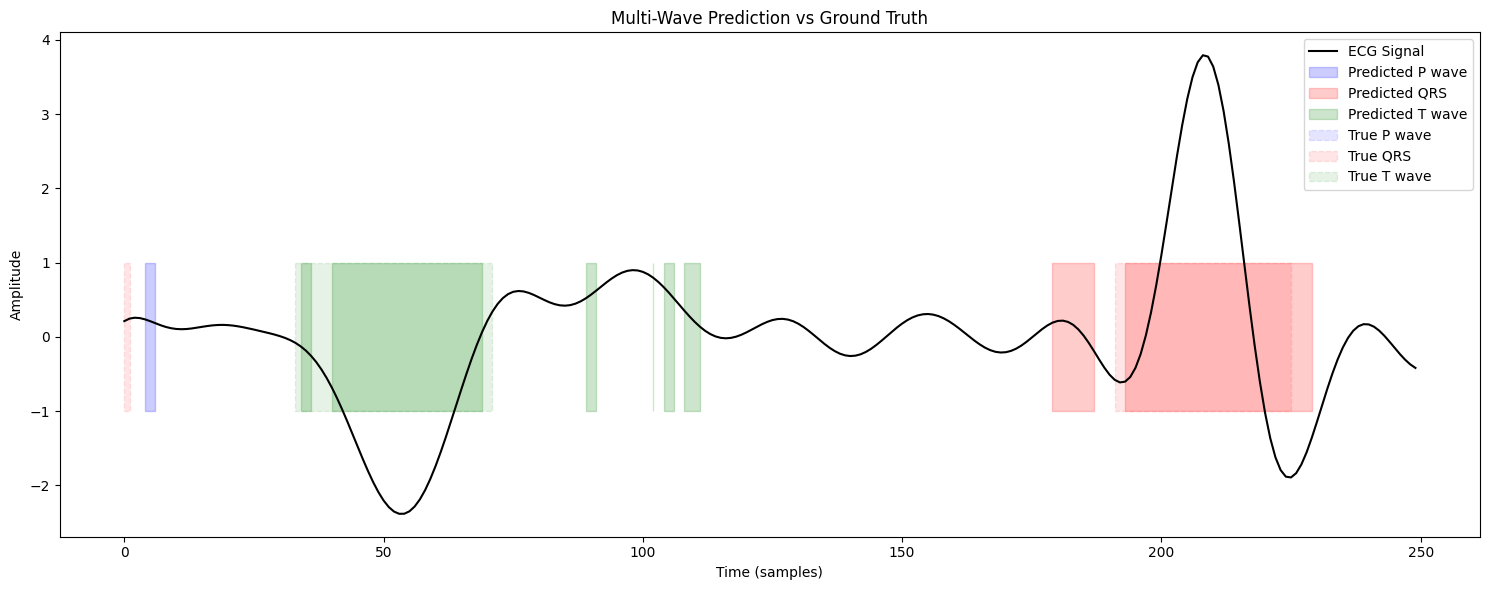

In [22]:
import matplotlib.pyplot as plt
import numpy as np

index = 0  # Sample to visualize
signal = X_test[index].flatten()
pred_mask = y_pred[index]
true_mask = y_test[index]
time = np.arange(len(signal))

plt.figure(figsize=(15, 6))
plt.plot(time, signal, color='black', label='ECG Signal')

# Plot predicted masks
plt.fill_between(time, -1, 1, where=pred_mask[:, 0] > 0.5, color='blue', alpha=0.2, label='Predicted P wave')
plt.fill_between(time, -1, 1, where=pred_mask[:, 1] > 0.5, color='red', alpha=0.2, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=pred_mask[:, 2] > 0.5, color='green', alpha=0.2, label='Predicted T wave')

# Plot ground truth masks
plt.fill_between(time, -1, 1, where=true_mask[:, 0] > 0.5, color='blue', alpha=0.1, label='True P wave', linestyle='dashed')
plt.fill_between(time, -1, 1, where=true_mask[:, 1] > 0.5, color='red', alpha=0.1, label='True QRS', linestyle='dashed')
plt.fill_between(time, -1, 1, where=true_mask[:, 2] > 0.5, color='green', alpha=0.1, label='True T wave', linestyle='dashed')

plt.title('Multi-Wave Prediction vs Ground Truth')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [23]:
from keras.saving import save_model

# Save the trained model
save_model(model,"/content/drive/MyDrive/Final project/QRS detection/TCN/first_QRS_T_P.keras")
model.save("/content/drive/MyDrive/Final project/QRS detection/TCN/first_QRS_T_P.keras")

# Model Test

In [ ]:

!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/mitdb' '/content/physionet.org/files/'

In [ ]:
from keras.saving import load_model
model = load_model("/content/drive/MyDrive/Final project/QRS detection/TCN/first_QRS_T_P.keras", custom_objects={
    'weighted_binary_crossentropy': weighted_binary_crossentropy
})


In [24]:
import wfdb

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_01/rec_1')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)


(5000,)


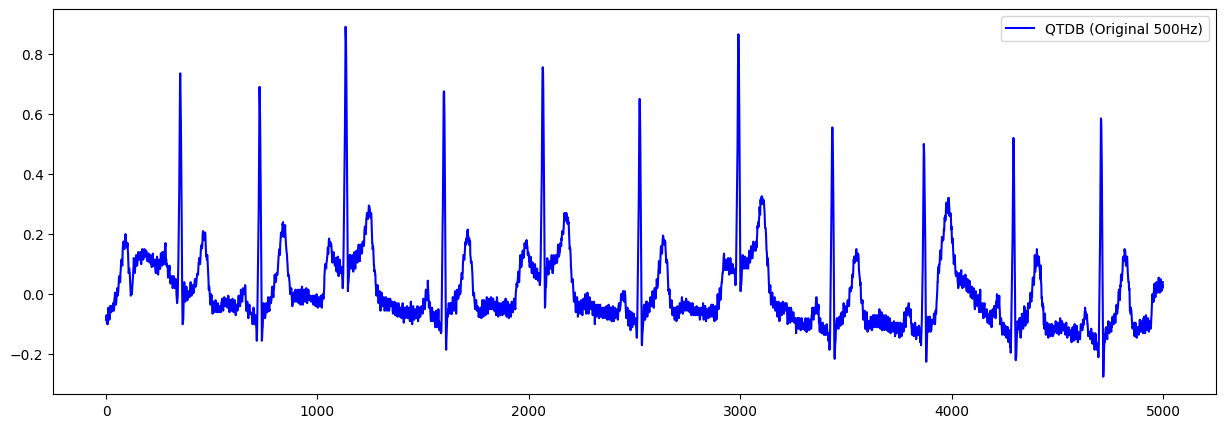

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(first_10_seconds, label=f"QTDB (Original {new_fs}Hz)", color='blue')
plt.legend()
plt.show()

In [26]:
from scipy.ndimage import median_filter, label
import numpy as np

def post_process_predictions(predictions, threshold=0.5, min_duration=20):
    """
    Apply post-processing to all predicted segments.

    predictions: np.array of shape (num_segments, segment_length, 3)
    threshold: float, classification threshold
    min_duration: int, minimum valid blob length in samples
    """
    num_segments, segment_len, num_classes = predictions.shape
    cleaned = np.zeros_like(predictions)

    for seg in range(num_segments):
        for cls in range(num_classes):
            # Threshold
            binary_mask = predictions[seg, :, cls] > threshold

            # Median filter to remove flickers
            smoothed = median_filter(binary_mask.astype(int), size=7)

            # Remove short blobs
            labeled_array, num_features = label(smoothed)
            for i in range(1, num_features + 1):
                blob = (labeled_array == i)
                if blob.sum() >= min_duration:
                    cleaned[seg, :, cls][blob] = 1
    return cleaned


In [27]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

first_10_seconds = normalize_signal(smooth_signal(bandpass_filter(first_10_seconds,fs=new_fs)))
first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
new_fs=250
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size , 250)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(18, 250, 1)


In [28]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.1).astype(int)  # Convert probabilities to binary masks
#print(y_pred[y_pred > 0])  # P


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[[8.7647535e-02 8.9282617e-02 9.2089683e-02]
  [1.4655286e-02 5.3353810e-01 1.4096138e-01]
  [3.6329824e-02 1.6608015e-01 1.7492944e-01]
  ...
  [2.7891609e-03 2.0725923e-03 8.4842241e-01]
  [8.0974860e-04 1.9877760e-03 7.2209376e-01]
  [2.5976208e-04 1.0799998e-03 4.6924603e-01]]

 [[2.0379861e-01 1.2500130e-01 3.4431079e-01]
  [3.0185282e-01 3.8139388e-02 3.2533988e-01]
  [2.4260558e-01 2.0980572e-02 3.0760783e-01]
  ...
  [1.0113649e-05 9.9808866e-01 4.8980241e-05]
  [6.7858746e-06 9.9758244e-01 6.8728579e-05]
  [4.3918512e-06 9.9031222e-01 7.3876523e-05]]

 [[1.0907774e-02 1.9729283e-01 2.5243250e-01]
  [6.0437224e-03 7.5515389e-02 3.1884134e-01]
  [4.5622964e-03 1.1508224e-01 4.3441996e-01]
  ...
  [1.1435828e-02 7.4148746e-05 3.9389729e-04]
  [1.8579690e-02 9.3465169e-05 5.2037515e-04]
  [2.3881197e-02 8.9040332e-05 7.1207574e-04]]

 ...

 [[1.3768461e-02 1.6773245e-01 2.2251506e-01]
  [9.4942292e-03 5.6551799e-02 2.3733431e-01]
  [7.7907066e-

In [29]:
# Example:
y_pred_clean = post_process_predictions(y_pred, threshold=0.5, min_duration=int(0.03 * new_fs))  # ~30ms


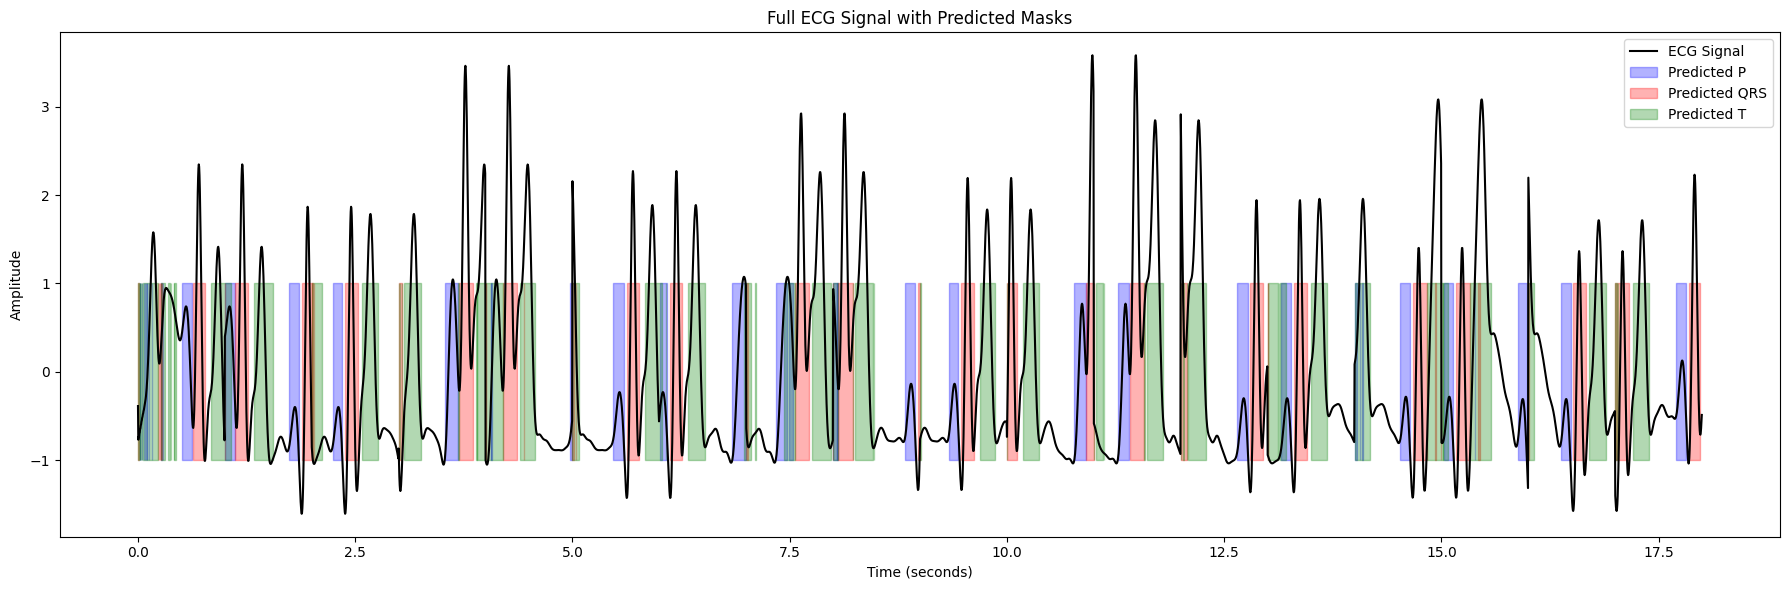

In [30]:
import matplotlib.pyplot as plt

full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

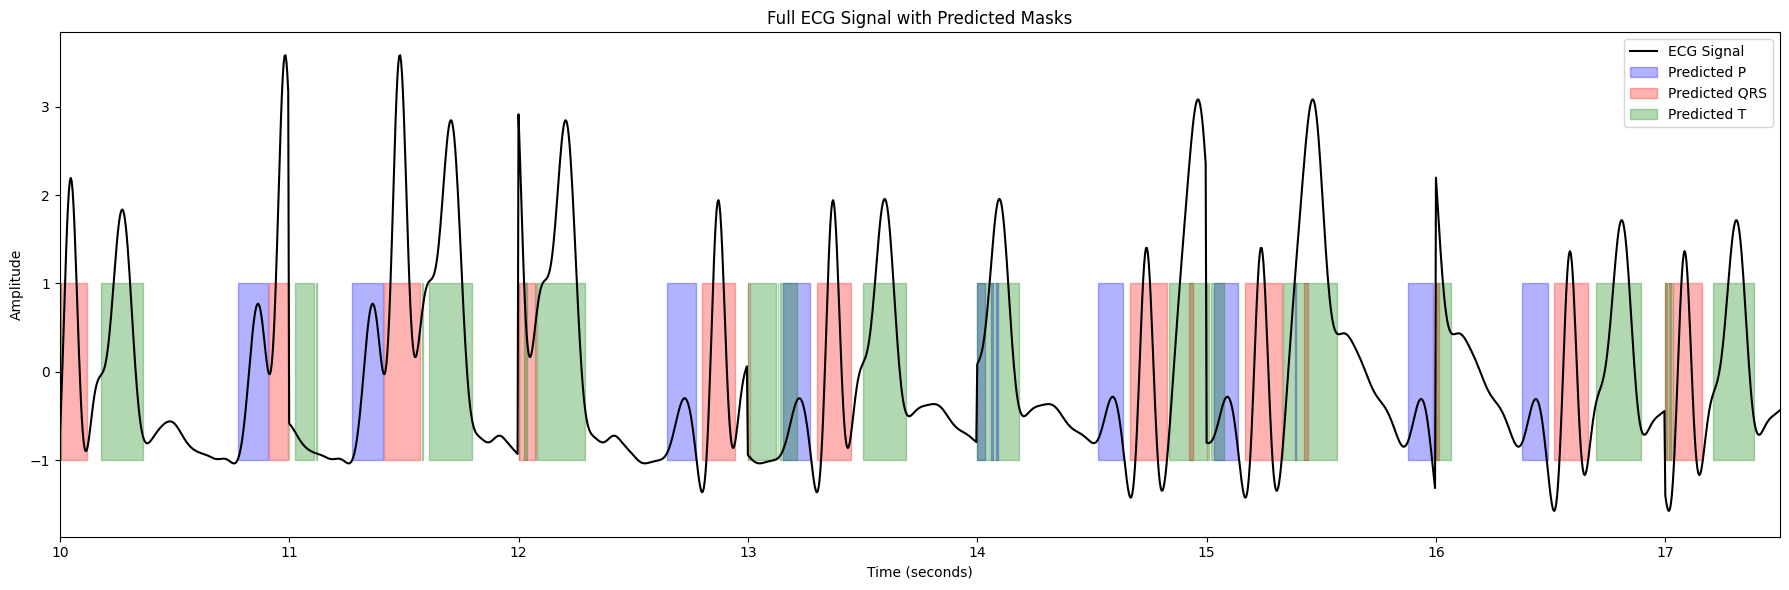

In [32]:
full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.xlim(10, 17.5)  # Zoom into 5s to 7s
plt.show()